In [31]:
#from google.colab import drive
#drive.mount('/content/drive')

import pandas as pd
import numpy as np
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import nltk.corpus
import nltk
import string
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
import seaborn as sns
import plotly.express as px
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import copy, pickle
from sklearn.metrics import cohen_kappa_score, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF, LatentDirichletAllocation
from statistics import mode
from statistics import median

mpl.style.use('ggplot')
nltk.download('subjectivity'); nltk.download('punkt');
nltk.download('stopwords'); nltk.download('wordnet');

[nltk_data] Downloading package subjectivity to C:\Users\Alex
[nltk_data]     Geiger\AppData\Roaming\nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Alex
[nltk_data]     Geiger\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Alex
[nltk_data]     Geiger\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Alex
[nltk_data]     Geiger\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Squid Games Review IST 736
*Alex Geiger, Kyle Walter, Eric Arnold, John Hoyle*

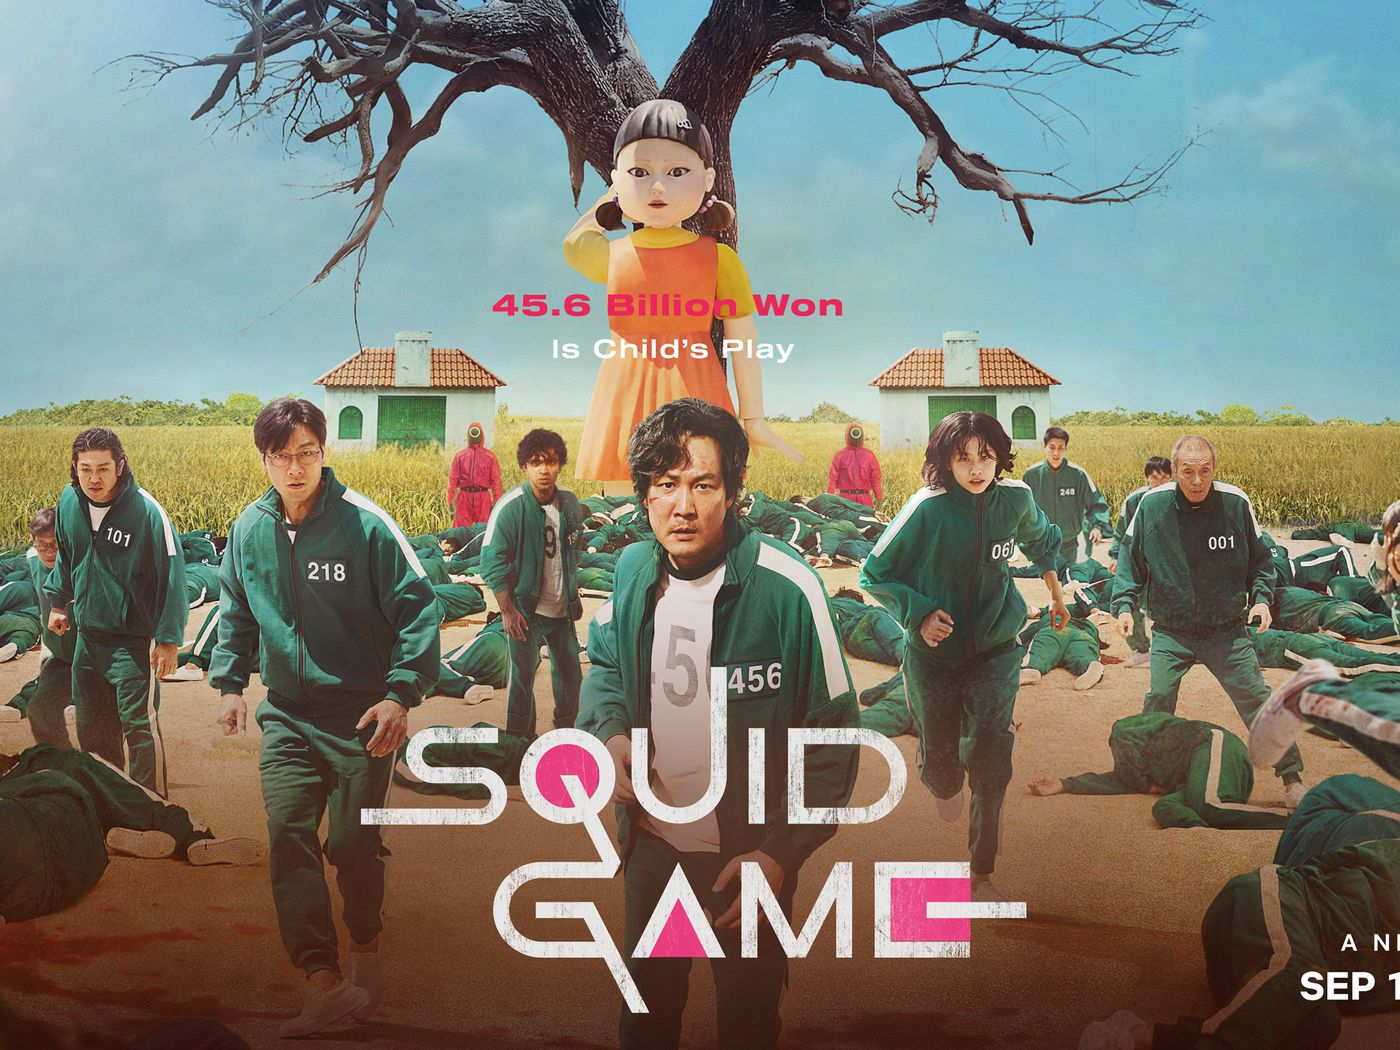
---------------

## Table of Contents

**Importing Data Star Analysis**
* [Importing The IMBD Data](#Importing-The-IMBD-Data)
* [Importing the Twitter Data](#Importing-the-Twitter-Data)
* [Star Distribution Analysis](#Star-Distribution-Analysis)

**Balancing the Data, Feature Curation, Corpus Analysis**
* [The Unbalanced Conundrum](#The-Unbalanced-Conundrum)
* [Feature Curation Algorithm](#Feature-Curation-Algorithm)
    * [Preprocess the reviews](#Preprocess-the-reviews)
    * [Word Freqency Distribution Analysis](#Word-Freqency-Distribution-Analysis)
    
**Training The MNB and SVM Models**
* [Multinomial Naive Bayes Model](#Multinomial-Naive-Bayes-Model)
    * [Model Optimization Data Structure Overview](#Model-Optimization-Data-Structure-Overview)
    * [Feature Selection and Model Tuning Visiualization](#Feature-Selection-and-Model-Tuning-Visiualization)
    * [Training The MNB Offical Models](#Training-The-MNB-Offical-Models)
    * [Analysis of Positive Words](#Analysis-of-Positive-Words)
    * [Model KPI Analysis](#Model-KPI-Analysis)
    * [Model Data Structure](#Model-Data-Structure)
    * [Saving the Vectorizer and Models](#Saving-the-Vectorizer-and-Models)
* [Support Vector Machines](#Support-Vector-Machines)
    * [SVM Result Analysis](#SVM-Result-Analysis)

**Applying the MNB Model**
* [Loading The Model and Generating IMDB Predictions](#Loading-The-Model-and-Generating-IMDB-Predictions)
* [Loading The Model and Generating Twitter Predictions](#Loading-The-Model-and-Generating-Twitter-Predictions)
* [Distribution Comparitive Analysis](#Distribution-Comparitive-Analysis)
* [Average Predicted Star Score Analysis](#Average-Predicted-Star-Score-Analysis)

**LDA Analysis**
* [Creating Features for LDA](#Creating-Features-for-LDA)
* [Fitting The LDA Model](#Fitting-The-LDA-Model)
* [Visualizing The Topics](#Visualizing-The-Topics)
* [Topic Star Analysis](#Topic-Star-Analysis)


**Conclusion**
* [Conclusion](#Conclusion)
* [Next Steps and Limitations](#Next-Steps-and-Limitations)
* [Links to Data and Related Works](#Links-to-Data-and-Related-Works)


## Introduction and Buisness Value
Netflix purchased the South Korean TV series Squid Games. Season 1 has received resounding praise from many critics; however, this leaves Netflix with a big decision. Should they finance a second season or move onto other projects? To decide, Netflix has reached out to SmartText to research the public sentiment of the show.  
  
The goal of the report is to utilize text mining techniques to gauge public sentiment and suggest ways of improving the show. Many Motion Picture Studios have realized the power of online reviews and have attempted to adjust their production activities in response to online reviews to increase their audience. TV shows are unique in the realm of e-commerce due to the nature of entertainment as a commodity. Online reviews of TV shows provide insight into what people want to see on their streaming service. Customer sentiment has always played a significant role in consumer decision-making, however today with the help of data science, new techniques can be applied and give organizations like Netflix the edge. 

## High-Level Overview
It was determined that IMDB both for the small size of the dataset and the more aficionado nature of the reviewers would likely be less reflective of the public overall. Hence, the need for Twitter data to help shed light on what the public thought of the Squid Game Series. One notable assumption is that Twitter accurately represents public sentiment. In order to assess the public sentiment of tweets, models are trained using the IMDB data. Once the models are trained they can then be applied to assess the general public's sentiment through analysis of tweets about squid games. After, topic analysis will provide insight into different opportunities for improving the show



## Importing The IMBD Data

The IMDB dataset from Kaggle consisted of 1,186 user reviews. The data contain both the review and the number of stars the reviewer had given the production. The scores can be utilized as sentiment indicators to train a model.

To preprocess the raw IMDB data several techniques had to be applied. First, the review score or number of stars the user had given production had to be derived from the `Review Rating`. The rating was formated as a string i.e. 9/10 which had to be converted to a numeric value.

* `User_name` The user name of the account that posted the review
* `Review title` The title of the user's review
* `Review Rating` The rating of the review
* `Review Date` The date the user posted the review
* `review` The review text body
* `score` The review rating converted to an integer value

[link to data](https://www.kaggle.com/deepcontractor/squid-game-imdb-user-reviews)

In [59]:
path = '/content/drive/MyDrive/'
path = 'data/'

# reviews data saved as data.csv
df=pd.read_csv(path + 'reviews.csv')\
            .drop(columns=['Unnamed: 0'])\
            .rename(columns=dict(Review_body = 'review'))

#reviews converted to dataframe called df
df['score'] = df['Review Rating'].apply(lambda x: int(x.split('/')[0]))

# display the head of the dataframe
df.head(3)

,User_name,Review title,Review Rating,Review date,review,score
0,Leofwine_draca,A new TV classic,10/10,9 October 2021,"Just finished up SQUID GAME, the Korean TV sho...",10
1,kosmasp,Just a game,9/10,10 October 2021,"Well multiple games actually, but even that yo...",9
2,Tweekums,Games to die for,10/10,11 October 2021,This runaway hit from South Korea is centred o...,10


## Importing the Twitter Data
It was determined that for measuring the general public’s sentiment on the Squid Games the best source of a public forum would be Twitter from Kaggle. Although there are many columns in the data, the most important is the `user_name` and `text` columns. See descriptions below for more detail.

* `user_name` The username of the tweeter
* `text` The text body or tweet.

[link to data](https://www.kaggle.com/deepcontractor/squid-game-netflix-twitter-data)

In [33]:
path = "/content/drive/MyDrive/twtter_squid_games.zip"
path = "data/tweets_v8.csv"

tweets = pd.read_csv(path)
tweets[['user_name','text']].tail(3)

,user_name,text
80016,Omo K-Pop News,Back &amp; Forth Between ‘Squid Game’ Creator ...
80017,🎃Pumpkin💀Queen 🕸,So what sort of games do you think they'll pla...
80018,levi do lay,@venancio_taylor @tracklist cala a boca swifte...


## Star Distribution Analysis
Upon analysis of the IMDB data, it is evident the data score distribution is unbalanced and positively skewed. To balance the data SmartText employed various analytical methods including oversampling and undersampling the data to no avail. Since Oversampling lead to overfitting and Undersampling lead to a feature space that was just too small. In the next section, we will discuss how we solved the conundrum in more detail.

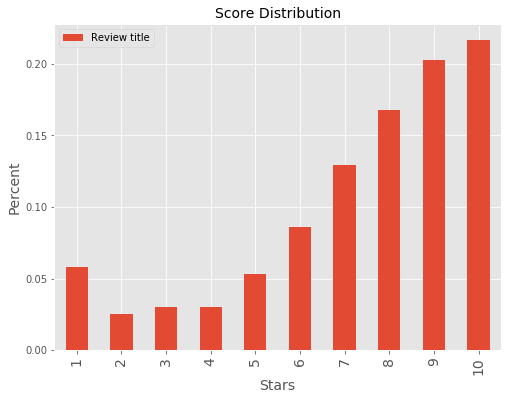

In [34]:
(df.groupby("score")['Review title'].count()/df.shape[0])\
        .reset_index()\
        .plot(x='score', y='Review title',kind='bar',figsize=(8,6))

# setup plot labels
plt.title("Score Distribution",fontsize=14)
plt.ylabel("Percent",fontsize=14)
plt.xlabel("Stars",fontsize=14)
plt.xticks(fontsize=14);

## The Unbalanced Conundrum

During the initial assessment of the data, it was observed that the rating of the IMDB data was highly skewed towards the higher end of the range. During the initial model trials, the data was split into either negative sentiment with a score of 5 or less and positive sentiment reflecting those values greater than 5. The class label was observed to be unbalanced as almost 1000 records of 1185 records in the Kaggle set were of the positive class. 

Machine learning models trouble accurately predicting when the data is highly unbalanced. To counteract the unbalanced data, three statistical methods were employed. 

The first was over-sampling. The records in the IMDB dataset were assigned weights that were the inverse of the sentiment class, and the records were sampled till 2000 records were drawn. Although the data was balanced, the negative cases appeared in both the training and testing data. As a result, it was determined the method was not to be utilized.

The other method reviewed was under-sampling, whereby all the negative records would be sampled while only the same number of positive records would be pulled from the dataset. It was decided that this wouldn’t provide enough data for the training of the model since it would likely be missing words that could indicate positive sentiment. Therefore, a different method of class balance was needed. 

Since neither method had worked, it was decided to create a synthetic well-balanced label derived from a review's stars. In total five different categories were quantitatively defined:

* Very negative, 0 = [1,5] 
* Negative, 1 = [6,7]
* Neutral, 2 = [8,8]
* Positive, 3 = [9,9]
* Very Positive, 4 = [10,10]


In [60]:
df['label'] = 0
df.loc[(df.score > 5) & (df.score <= 7),'label'] = 1
df.loc[(df.score > 7) & (df.score < 9),'label'] = 2
df.loc[df.score == 9,'label'] = 3
df.loc[df.score == 10,'label'] = 4

def mapNames(x):
    if x == 0: return "very negitive"
    elif x == 1: return "negitive"
    elif x == 2: return "neutral"
    elif x == 3: return "positive"
    elif x == 4: return "very positive"
    else: raise Exception("could not be found")
        
# add label names using a lambda function
df['labelNames'] = df.label.apply(lambda x: mapNames(x))

# display distribution analysis
stats = df.groupby(['label','labelNames']).agg(dict(score=['min','max','count']))
stats[('score', 'count')] /= df.shape[0]*(1/100)
stats.columns = ['min score','max score', 'distribution']
stats.reset_index()

,label,labelNames,min score,max score,distribution
0,0,very negitive,1,5,19.746835
1,1,negitive,6,7,21.518987
2,2,neutral,8,8,16.793249
3,3,positive,9,9,20.253165
4,4,very positive,10,10,21.687764


## Visualize The Balanced Data
From the bar graph it is evident the data is balanced far better than how it had been with the raw score.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

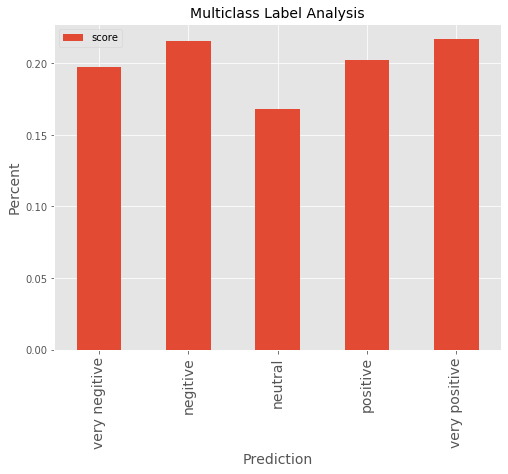

In [36]:
(df.groupby(['labelNames','label']).count()/df.shape[0]).\
                reset_index().sort_values("label").plot(x='labelNames',
                                                        y='score',
                                                        kind='bar',
                                                        figsize=(8,6))

plt.ylabel("Percent",fontsize=14)
plt.xlabel("Prediction",fontsize=14)
plt.title("Multiclass Label Analysis",fontsize=14)
plt.xticks(fontsize=14)

## Feature Curation Algorithm
When it comes to making any good dish the most important thing is the ingredients that you are cooking with. The same is true with the features in a model. Good features make for a great model. To understand what text mining techniques, make for the best ingredients in a predictive model, SmartText developed a proprietary algorithm. The algorithm creates several different variants of text by combining different text mining methods. The methods include lowercasing the text, regular expression, lemmatization, stop word removal, and stemming. These various algorithms were combined in diverse ways to preprocess text that was to be run through the Count Vectorizer object. 

To streamline the feature curation approach for any dataset the class `TextMiningClass` was developed which ensured the text is processed consistently every time. The class featured several definitions including `preprocess data`, `load`, `save` and `predict`. These methods allowed for generating Squid Game sentiment predictions with ease. 

The following class creates four distinctly different types of distinct features by applying techniques touted by top-tier universities. The techniques applied to the review text data include all of the following methods.

* Lowercase the text
* Applies regular expression
* Applies lemmatization
* Removes stop words
* Applies Stemming

In [143]:
class TextMiningClass(object):
    """
    The concrete methods include
    preprocessData - pre-process the review data
    load - load in the model and count vectorizer
    predict - generate predictions from all n-models created via cross validation
    """
    def __init__(self):
        
        # setup the lemmatizer and stemmer objects
        self.lemmatizer = WordNetLemmatizer()
        self.ps = nltk.PorterStemmer()
    
        # define all stop words for stop word removal
        self.stopWordList = stopwords.words("english")
        self.stopWordList = [w.lower() for w in self.stopWordList]
        self.stopWordList += ['mike',"also", "and", "are", "you", "of",
                              "let", "not", "the", "for", "why", "there",
                              "one", "which", "too","wa","charact"]
        
    # preprocess the data
    def preprocessData(self,df, colName="review", removeEnding = True):
        """
        Info:    preprocess text data for squid game sentiment analysis
        Inputs:  df (DataFrame) a dataframe will a squid game review column
                 colName (str) the column name of the squid game review column
                 removeEnding (bool) Only True for the IMDB data
        outputs: None the original dataframe will be updated.
        """
        # check to see if you need to remove the ending
        if removeEnding:
            df['review_cleaned'] = df[colName].apply(lambda x: x[:-215])
        else:
            df['review_cleaned'] = df[colName]
            
        # clean up words
        df['review_exp1'] = df['review_cleaned'].apply(lambda x: re.sub('[^A-Za-z]',' ',x.lower()))
        
        # removed the stop words in the text
        df['lem_review_rm_sw'] = df['review_exp1'].apply(lambda x: self.rem_stopWords(x.split(" ")))

        # apply the lemmatizer
        df['lem_review'] = df['review_exp1'].apply(lambda x: self.lemmatize_words(x.lower().split(" ")))

        # removed the stop words in the text
        df['lem_review_rm_sw'] = df['lem_review'].apply(lambda x: self.rem_stopWords(x.split(" ")))

        # apply stemming
        df['lem_review_rm_sw_stem'] = df['lem_review_rm_sw'].apply(lambda x: self.stemming_alg(x.split(" ")))
    
    # load the pickled data
    def load(self,filename='pickledData.pkl'):
        """
        When you have saved the model you can load it in 
        via a pickle file. The file needs to have the countvectorizer
        and a dictionary of models.
        """
        with open(filename, 'rb') as f:
            self.vectorizer, self.models = pickle.load(f)
            
    def save(self, vectorizer, models, filename = "pickledData.pkl"):
        """
        Info: save the models and count vectorizer object
        Inputs: vectorizer - the count vectorizer to train the model
                models - a dictionary of trained models.
                filename - the name of the file to save the data to.
        """

        with open(filename, 'wb') as fout:
            pickle.dump((vectorizer, models), fout)

    # generate predictions
    def predict(self,df,feat_col: str):
        """
        Info:    Generate predictions across all folds
        Inputs:  feat_col (str) The name of the feature column to tokenize
        outputs: (DataFrame) a dataframe with all the model predictions
        """
        predictions = pd.DataFrame()
        
        # fit the transformation
        feats = self.vectorizer.transform(df[feat_col])
        
        for n_fold, model in self.models.items():
            predictions[str(n_fold)] = model.predict(feats)
            
        def takeTheMode(x):
            try:
                return mode(x)
            except Exception as e:
                return int(median(x)//1)
        
        predictions["answer"] = predictions.agg(takeTheMode,axis=1)
        predictions["maxAnswer"] = predictions.max(axis=1)
        predictions["text"] = df[feat_col]
        return predictions
    
    def lemmatize_words(self,words):
        return " ".join([self.lemmatizer.lemmatize(w) for w in words])
    
    def rem_stopWords(self,wordList):
        # remove all the stop words
        return " ".join([ w for w in wordList if w not in self.stopWordList])
    
    def stemming_alg(self,text):
        # apply stemming
        return " ".join([self.ps.stem(word) for word in text])
    

## Preprocess the reviews
Next, a `TextMiningClass` Object was instantiated to preprocess the review data using the proprietary class definitions developed for the course's final project. The definition `preprocessData()` is called to pre-process the IMDB data in the DataFrame `df`

In [144]:
# create a the pre-processing object
prepObj = TextMiningClass()

# preprocess the reivew data
prepObj.preprocessData(df)

## Word Freqency Distribution Analysis
Perform frequency distribution analysis to gain insight into the review data. To do this the column `lem_review_rm_sw_stem` documents are tokenized into the variable `tokens`. After the class `FreqDist` provides insight into the frequency of words in the collection of documents. The most common words were `game`, `show`, `want`, `series` and `character`. From a qualitative perspective, these words indicate this game show is a must watch.

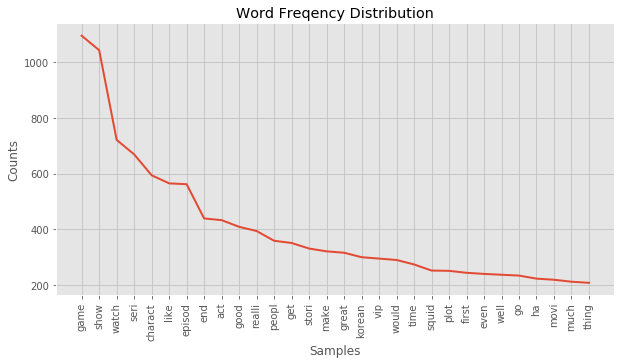

In [145]:
# tokenize the words
tokens = word_tokenize(' '.join(df['lem_review_rm_sw_stem'].tolist()))

# create a distribution plot
fdist = FreqDist(tokens)

plt.figure(figsize=(10,5))
fdist.plot(30,title="Word Freqency Distribution");

## Multinomial Naive Bayes Model
One of the most coveted models in Machine learning is the Multinomial Naive Bayes model. The reason the Multinomial model was used over the Bernoulli model was that it looks at word frequency instead of the presence or absence of a word (1). One of the problems with a Multinomial Bayes Model is when any one of the conditional probabilities is zero, because the posterior probability will be zero (1). To overcome this problem the sci-kit-learn MNB model features an Additive Laplace smoothing parameter in their software called alpha. 

The optimization algorithm's hyperparameter consisted of two key ingredients. The first was the features that went into the model and the second was alpha. An exhaustive search algorithm iteratively assessed each model's performance for unique alpha and feature combinations. To validate the trained models, cross-validation ensured the result showed improvement over the baseline model. Every unique combination of alpha and feature was responsible for training 15 models, one for each of the 15 folds. 

Inside the algorithm, statistics from training the model were recorded in addition to the feature and alpha values. The performance was recorded to provide insight into what worked and what did not work. After the algorithm had finished, the analysis of the recorded data shed light on the optimal hyperparameters for the best-performing model. 

* Over 1,800 Naive Bayes models were trained with different types of features derived from variety of text mining techniques via the TextMiningClass object. The features curation techniques include:
    * stop word removal
    * stemming 
    * regular expression
    * Lemmatization
* The smoothing parameter alpha was optimized.
* The advantages of the Naive bayes model was that it was fast and handled the large feature space with ease


In [150]:
review_scores = pd.DataFrame()
review_feats  = pd.DataFrame()

for alphaVal in np.linspace(.5,3,30):
    for feat_col in ["lem_review_rm_sw_stem",
                     "lem_review_rm_sw",
                     "review_exp1",
                     "review_cleaned"]:

        # there were a total of roughly 28940 words
        vectorizer = CountVectorizer(ngram_range=(1,2),
                                     min_df=4, 
                                     lowercase=True)

        # fit the transformation, get the words, setup the kfolds
        feats = vectorizer.fit_transform(df[feat_col])
        words = vectorizer.get_feature_names() 
        kf = KFold(n_splits=15, random_state=120, shuffle=True)
        
        # setup targets
        review_target = df["label"]
        
        # setup the loops required parameters
        fold_n, models = 0, dict()

        for tr_idx, te_idx in kf.split(feats,review_target):

            tr_X, tr_label = feats[tr_idx], review_target[tr_idx]
            te_X, te_label = feats[te_idx], review_target[te_idx]

            model = MultinomialNB(alpha = alphaVal)
            model.fit(tr_X,tr_label)

            te_score = [(model.predict(te_X) == te_label).mean()]
            tr_score = [(model.predict(tr_X) == tr_label).mean()]

            temp_feats = pd.DataFrame()
            temp_feats['features'] = words
            for classID in [0, 1, 2, 3, 4]:
                temp_feats[model.classes_[classID]] = model.feature_log_prob_[classID]
            temp_feats['fold'] = fold_n
            temp_feats['review_column'] = feat_col

            # add the model data to the DataFrame
            data = dict(fold=fold_n,test=te_score,train=tr_score,feats=[feat_col],alpha=[alphaVal])
            review_feats = pd.concat([review_feats,temp_feats])
            review_scores = pd.concat([review_scores,pd.DataFrame(data)])
            fold_n += 1

review_scores.reset_index(inplace=True,drop=True)

## Model Optimization Data Structure Overview
The DataFrame `review_scores` takes all the information gathered from the Feature Selection and Model Tuning algorithm to provide insight on how to train the best model. The review scores consist of four columns which are as follows:
* `feats` the feature pre-processing technique
* `alpha` The value of the Naive Bayes smoothing parameter alpha.
* `train` The accuracy of the training data set during cross-validation.
* `test` the accuracy of the test data set during cross-validation

In [151]:
review_scores.groupby(["feats","alpha"])[['train','test']].mean().sort_values("alpha").reset_index()

,feats,alpha,train,test
0,lem_review_rm_sw,0.500000,0.886317,0.406751
1,review_exp1,0.500000,0.936829,0.420253
2,review_cleaned,0.500000,0.936769,0.419409
3,lem_review_rm_sw_stem,0.500000,0.882821,0.426160
4,review_exp1,0.586207,0.933816,0.416034
...,...,...,...,...
115,lem_review_rm_sw,2.913793,0.814888,0.404219
116,lem_review_rm_sw_stem,3.000000,0.811814,0.418565
117,lem_review_rm_sw,3.000000,0.812779,0.405907
118,review_cleaned,3.000000,0.851718,0.392405


## Feature Selection and Model Tuning Visiualization
In the following graph, we visualize the DataFrame `review_scores`. The plot features an x-axis as the value of the smoothing parameter `alpha`. Alpha is one of the hyperparameters in the sklearn Naive Bayes model. Next, the y-axis features the average test accuracy across all folds during cross-validation. The color is indicative of the feature set responsible for training the models. 

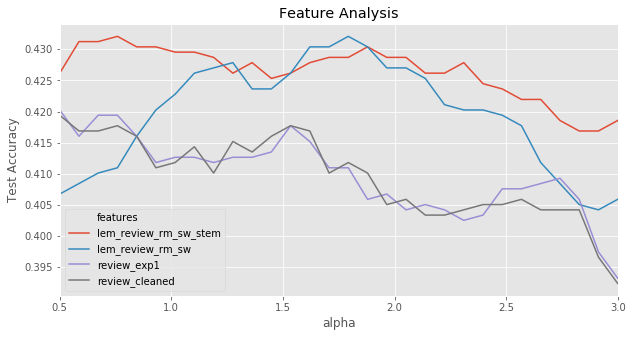

In [152]:
import seaborn as sns

plt.figure(figsize=(10,5))
sns.lineplot(
    data=review_scores.rename(columns=dict(feats='features')),
    x="alpha", y="test", hue="features", ci = None)
plt.title("Feature Analysis")
plt.xlim((review_scores['alpha'].min(),review_scores['alpha'].max()))
plt.ylabel("Test Accuracy");

## Training The MNB Offical Models
After the analysis of the results from Feature Selection and Model Tuning Visualization, it is evident that the optimal features used are `lem_review_rm_sw_stem` and the optimal alpha value is 0.93. In the next section, SmartText will these findings to train the official models which will be used to evaluate public sentiment.

In [159]:
# setup required variables
alphaVal = .93
feat_col = "lem_review_rm_sw_stem"

# setup datastructures to capture meta data
review_scores = pd.DataFrame()
review_feats  = pd.DataFrame()

# there were a total of roughly 28940 words
vectorizer = CountVectorizer(ngram_range=(1,2),
                             min_df=2, 
                             lowercase=True)

# setup the k-fold, fit the transformation, get the list of words
kf = KFold(n_splits=15, random_state=120, shuffle=True)
feats = vectorizer.fit_transform(df[feat_col])
words = vectorizer.get_feature_names()

# setup targets, setup required parameters
review_target = df["label"]
fold_n, models = 0, dict()

for tr_idx, te_idx in kf.split(feats,review_target):

    # create training and testing data
    tr_X, tr_label = feats[tr_idx], review_target[tr_idx]
    te_X, te_label = feats[te_idx], review_target[te_idx]

    # setup and train the model
    model = MultinomialNB(alpha = alphaVal)
    model.fit(tr_X,tr_label)
    models[fold_n] = copy.deepcopy(model)
    
    # curate feature data
    temp_feats = pd.DataFrame(dict(features=words))
    for classID in [0, 1, 2, 3, 4]:
        temp_feats[model.classes_[classID]] = model.feature_log_prob_[classID]
    temp_feats['fold'] = fold_n
    temp_feats['review_column'] = feat_col
    
    # generate test and training scores
    te_score = [(model.predict(te_X) == te_label).mean()]
    tr_score = [(model.predict(tr_X) == tr_label).mean()]
    kappaScoreTest = cohen_kappa_score(model.predict(te_X),te_label)
    kappaScoreTrain = cohen_kappa_score(model.predict(tr_X),tr_label)
    
    # add the model meta data to the DataFrame
    data = dict(fold=fold_n,testAcc=te_score,trainAcc=tr_score,kappaTest=[kappaScoreTest],kappaTrain=[kappaScoreTrain],feats=[feat_col],alpha=[alphaVal])
    review_feats = pd.concat([review_feats,temp_feats])
    review_scores = pd.concat([review_scores,pd.DataFrame(data)])
    fold_n += 1

review_scores.reset_index(inplace=True,drop=True)

## Analysis of Positive Words
The following table highlights the empirical log probability of features given a class. The column space represents the classes and the row space represents the words. Each element is the empirical log probability of features given a class. The top 10 words across all folds include best, love, like, character, episode, one, game, series, watch, and show.

In [160]:
temp_feats.groupby('features')[[0,1,2,3,4]].mean().sort_values(4,ascending=False).head(10)

,0,1,2,3,4
features,,,,,
show,-4.818815,-4.676812,-4.536015,-4.550779,-4.574773
watch,-5.106643,-5.094849,-5.170211,-4.991071,-4.592376
seri,-5.269265,-5.310316,-5.282552,-4.951203,-4.616340
game,-4.590594,-4.496503,-4.584118,-4.691120,-4.659709
episod,-5.289081,-4.866629,-5.455152,-5.459790,-5.328276
charact,-5.394519,-5.040101,-5.135403,-5.228697,-5.340710
like,-5.289081,-4.902088,-5.343839,-5.555191,-5.460167
love,-7.259506,-6.839884,-6.160977,-5.912295,-5.579838
best,-7.334001,-6.507820,-6.764533,-6.308302,-5.595856


## Model KPI Analysis
* Test Accuracy of 0.431224
* Train Accuracy of 0.943098
* Kappa Test: 0.283509
* Kappa Train: 0.928658

In [161]:
pd.DataFrame(review_scores.mean()).tail(5).rename(columns={0:'KPI score'})

,KPI score
testAcc,0.431224
trainAcc,0.943098
kappaTest,0.283509
kappaTrain,0.928658
alpha,0.930000


## Model Data Structure
Now that SmartText data scientists have curated all 15 models, each model must be saved in a single pickle. The required data structure the models are saved as is a dictionary. The keyspace of the dictionary corresponds to the fold ID and the value is associated with its corresponding model.

In [50]:
models

{0: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 1: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 2: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 3: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 4: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 5: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 6: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 7: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 8: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 9: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 10: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 11: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 12: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 13: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True),
 14: MultinomialNB(alpha=0.93, class_prior=None, fit_prior=True)}

## Saving the Vectorizer and Models
Both the models and Count Vectorizer are saved to a pickle file. The purpose of this is to be able to avoid having to retrain all the models after training. The definition in the class is simple and easy to use. All that is needed is for the user to pass in the count vectorizer object and dictionary of models and the class definition `save` will take care of the rest.

In [162]:
prepObj.save(vectorizer, models)

## Support Vector Machines
As a secondary model to learn the text classification on the IMDB data set, support vector machines was also trained on the data. Support vector machines try to separate the data into multiple dimensions and looks to insert a plane as a divisor between the data points. This lazy learner method makes SVM models work quite well with highly dimensional data such as text.

Using Radial Based Kern with 10-fold cross validation it was seen the data trained to accuracy just over 83%, underperforming the Naïve Bayes model by 10%. In addition, the fit time for the method is considerably longer. The model was trained using grid search to find the optimum cost variation, and the time to run 360 models was slightly over 36 minutes compared to about 3 to run 1800 iterations of the Naïve Bayes. The cost parameter where the results reached the 83% accuracy on the training data 5.2, meaning the plane is misclassifying many points to achieve the correct result.

When the model was tried against test data, it preformed lower in F1 and Accuracy from the NB model thus was deemed not good for trials against the public data.

[go to top of page](#Table-of-Contents)

In [78]:
parameters = {'kernel':['rbf'],'C':np.arange(1,10,0.1)}
results = pd.DataFrame()
for feat_col in ["lem_review_rm_sw_stem","lem_review_rm_sw","review_exp1", "lem_review"]:
    
    # instantiate the model
    svm = SVC()
    smodel = GridSearchCV(svm, param_grid=parameters, cv = 10)

    # there were a total of roughly 28940 words
    vectorizers = CountVectorizer()

    # fit the transformation
    feats = vectorizers.fit_transform(df[feat_col])

    #fit the model
    smodel.fit(feats, df["label"])

    temp_df = pd.DataFrame(smodel.cv_results_) #convert results to a datafram
    temp_df["feat_col"]=feat_col # adds the feature column to the data frame
    results = pd.concat([results, temp_df]) #combines all the results
    del temp_df #deletes the temp df
    
results[results.columns[-5:]].head(5) #shows the results dataframe

,split9_test_score,mean_test_score,std_test_score,rank_test_score,feat_col
0,0.372881,0.383948,0.044939,90,lem_review_rm_sw_stem
1,0.364407,0.388185,0.043276,89,lem_review_rm_sw_stem
2,0.372881,0.394103,0.045330,88,lem_review_rm_sw_stem
3,0.398305,0.396632,0.044321,86,lem_review_rm_sw_stem
4,0.389831,0.395791,0.044604,87,lem_review_rm_sw_stem


## SVM Result Analysis
Here are the top 10 preforming Models of the support vector machines. The SVM did not out perform the MNB model. Therefore, the SVM will not be saved as an offical model.

In [79]:
results[['feat_col', 'mean_test_score', 'param_C']].\
sort_values('mean_test_score', ascending=False).\
head(10)

,feat_col,mean_test_score,param_C
45,lem_review_rm_sw_stem,0.425360,5.5
46,lem_review_rm_sw_stem,0.424519,5.6
65,lem_review_rm_sw_stem,0.424512,7.5
66,lem_review_rm_sw_stem,0.424512,7.6
37,lem_review_rm_sw_stem,0.424512,4.7
38,lem_review_rm_sw_stem,0.424512,4.8
44,lem_review_rm_sw_stem,0.424505,5.4
64,lem_review_rm_sw_stem,0.423672,7.4
63,lem_review_rm_sw_stem,0.423672,7.3
40,lem_review_rm_sw_stem,0.423672,5


## Loading The Model and Generating IMDB Predictions
First, a brand-new object `imdb_obj` is instantiated and loaded with the pickled data which includes both the dictionary of 15 models and the count vectorizer object. Once the data has been loaded into the object it is now ready to start generating the predictions.  The predictions are saved to the variable `predictions`. After the IMDB label distribution is saved to the variable `imdb_pres`.

In [82]:
imdb_obj = TextMiningClass()
imdb_obj.load('pickledData.pkl')
predictions = imdb_obj.predict(df,"lem_review_rm_sw_stem")
imdb_pres = predictions.groupby('answer')[["1"]].count()/predictions.shape[0]

## Loading The Model and Generating Twitter Predictions
Second, another brand-new object `twitter_obj` is instantiated and loaded with the pickled data which includes the same dictionary of 15 models and the count vectorizer object. Once the data has been loaded into the object, the twitter data must be preprocessed. After it is now ready to start generating the predictions. The twitter predictions are saved to the variable `twitter_predictions` and the distirbution of labels are saved to `twitter_results`.

In [83]:
twitter_obj = TextMiningClass()
twitter_obj.load('pickledData.pkl')
twitter_obj.preprocessData(tweets,"text",False)
twitter_predictions = twitter_obj.predict(tweets,"lem_review_rm_sw_stem")
twitter_results = twitter_predictions.groupby('answer')[["1"]].count()/twitter_predictions.shape[0]

## Distribution Comparitive Analysis
Using the trained models SmartText compared the distribution of predictions of the IMDB data to that of the Twitter data to see how non-movie aficionados compared to the run-of-the-mill tweeter. The objective is to identify public sentiment by assuming tweets accurately depict public sentiment.

* Over 80,000 tweets were assessed using the trained predictive models.
* Twitter was more netral than IMDB
* People on IMDB are more nuanced when it comes to film according to the data.
* The results of twitter were still vastly more positive,  just not as positive.
* Star analysis in the next section will show tweeters liked Squid games more than IMDB reviews so stay tuned.

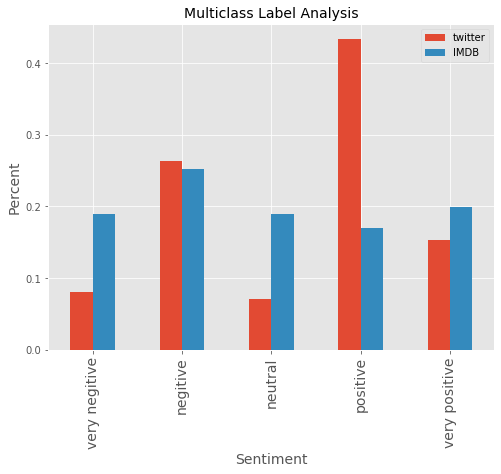

In [108]:
twitter_results_cleaned=twitter_results.rename(columns={"1":"twitter"}).reset_index()
imdb_pres_cleaned=imdb_pres.rename(columns={"1":"IMDB"}).reset_index()
simple=pd.merge(twitter_results_cleaned,imdb_pres_cleaned,on='answer')
simple['answer'] = simple.answer.apply(lambda x: mapNames(x))

simple.plot(x='answer',kind='bar',figsize=(8,6))
plt.ylabel("Percent",fontsize=14)
plt.xlabel("Sentiment",fontsize=14)
plt.title("Multiclass Label Analysis",fontsize=14)
plt.xticks(fontsize=14);

## Average Predicted Star Score Analysis
In this section, the assessed average star score of both the Twitter and IMDB datasets was reviewed. The IMDB dataset's average star score was 7.24 and the average Twitter star score was 7.94. Since the five labels did not directly correlate to the average star score, the number of stars of a label were estimated by averaging the minimum and maximum star for a label. For example, a very negative label had a minimum score of 1 and a maximum score of 5 so the average score for the negative label would be (5+1)/2 = 3. Next, we took the percent of a label and multiplied it by the average star score of a record to calculate the database's official average star score.

**How the label translates to an average star score**
* Very negative, 0 = [1,5] = average star score of 3
* Negative, 1 = [6,7] = average star score of 6.5
* Neutral, 2 = [8,8] = average star score of 8
* Positive, 3 = [9,9] = average star score of 9
* Very Positive, 4 = [10,10] = average star score of 10

,Star Score
twitter,7.938102
IMDB,7.240084


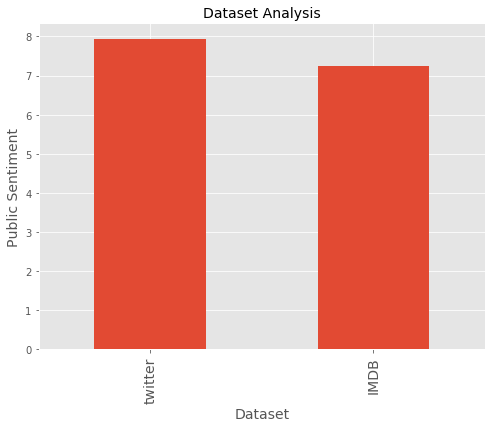

In [109]:
simple = simple.merge(stats.reset_index(),right_on='labelNames',left_on='answer')
simple['twitter'] = simple[['max score','min score']].mean(axis=1)*simple['twitter']
simple['IMDB'] = simple[['max score','min score']].mean(axis=1)*simple['IMDB']
simple[['twitter','IMDB']].sum().plot(kind='bar',figsize=(8,6))
plt.ylabel("Public Sentiment",fontsize=14)
plt.xlabel("Dataset",fontsize=14)
plt.title("Dataset Analysis",fontsize=14)
plt.xticks(fontsize=14);
pd.DataFrame(simple[['twitter','IMDB']].sum()).rename(columns={0:'Star Score'})

## Creating Features for LDA
The features for topic LDA are produced with the `CountVectorizer` object. The object works by converting a collection of documents to a sparse matrix of token counts. The feature space is kept to strictly unigram features because the objective is to understand general topics and a simple word count will suffice. After the object is instantiated it is fit. Lastly, a variable named words are saved and hold all the features or tokenized words. This will be used in an upcoming section for topic visualization so say tuned.

[go to top of page](#Table-of-Contents)

In [ ]:
#  A unigram term frequency vectorizer
vectorizer = CountVectorizer(encoding='latin-1', 
                             decode_error = 'strict',
                             binary=False,
                             min_df=8, 
                             lowercase=True,
                             stop_words='english')

# create the features for LDA
features = vectorizer.fit_transform(df['lem_review_rm_sw_stem'])

# save the feature space or words to a list variable
words = vectorizer.get_feature_names()

## Fitting The LDA Model
Latent Dirichlet Allocation or LDA with online variational Bayes algorithm summarizes the main topics of the IMDB text collection. The result of the LDA will provide insight into the main topics behind the squid game comentary. The number of topics used was 7. (2)

[go to top of page](#Table-of-Contents)

In [ ]:
# specify the number of topics
num_topics = 7

# set up the LDA object
model = LatentDirichletAllocation(n_components = num_topics, 
                                         max_iter = 1000, 
                                         learning_method = "online")

# fit the transformation the LDA model
LDA_Model = model.fit_transform(features)

## Visualizing The Topics
In the code, the results from the LDA analysis are displayed to gain valuable insight into the topics of Squid Game commentary. After an algorithm will assess the sentiment of the topics so stay tuned. (2)

**Top Three Topics**
* Topic 3 - The highly rated topic shows viewers enjoy the human and emotional side of the show.
* Topic 6 - highlights the English was dubbed very poorly. It is recommended that more money should be spent on dubbing the Korean show.
* Topic 5 - The dislike of the consistent killing of all of the main characters the audience had grown to love.


[go to top of page](#Table-of-Contents)

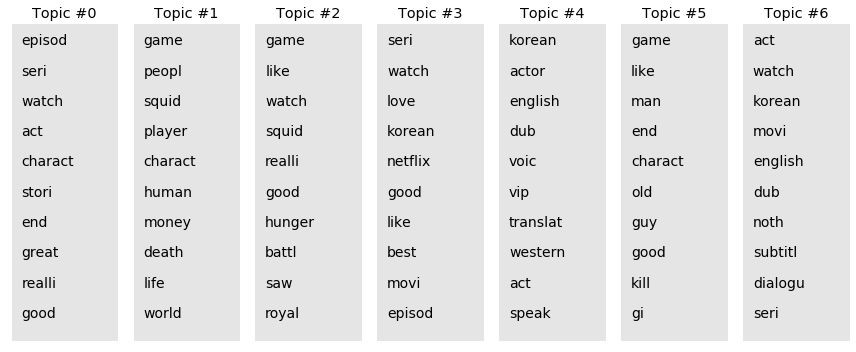

In [ ]:
import numpy as np

word_topic = np.array(model.components_)
word_topic = word_topic.transpose()

num_top_words = 10
vocab_array = np.asarray(words)
plt.figure(figsize=(12,5))
for t in range(num_topics):

    # create a sub plot
    plt.subplot(1, num_topics, t + 1) 
    plt.ylim(0, num_top_words + 0.5)

    # remove axis markings
    plt.xticks([]), plt.yticks([])
    plt.title('Topic #{}'.format(t))

    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = vocab_array[top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]

    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.1, num_top_words-i-0.2, word, fontsize=14)

plt.tight_layout()
plt.show()

## Topic Star Analysis
The following analysis looks at the average star rating for a topic. Since the output of LDA is a softmax layer a weighted average calculates the average stars per each topic. The weighted average is computed by first multiplying a review's topic probability by the number of stars for the review i.e. `Numerator Topic n` = `Topic n Probability` x `Star Rating`. Second, the sum of both of `Numerator Topic n` and `Topic n Probability` are taken. i.e. sum(`Numerator Topic n`) and the sum(`Topic n Probability`). Lastly divide these two to get the Topic star rating:

*Topic n Star Rating = sum(`Numerator Topic n`)/sum(`Topic n Probability`)*

[go to top of page](#Table-of-Contents)

In [ ]:
# create topic dataframes
topicsOriginal = pd.DataFrame(model.transform(features))
topics = topicsOriginal.copy()

# save over the number of stars or score to the topic DataFrame
topics['score'] = df['score']

for col in topicsOriginal.columns:
    # continue if the column is the score
    if col == "score": continue
    # else calculate the numerator of the fration
    topics[str(col)+'_score'] = topics[col]*topics['score']
    
# that the sum across all columns
answers = topics.mean()

# create a results data frame
results = dict()
for col in topicsOriginal.columns:
    # continue if the column is the score
    if col == "score": continue
    #  calculate the weighted average
    results["topic "+str(col)] = [answers[str(col)+'_score']/answers[col]]

# display the average start for each topic
pd.DataFrame(results)

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6
0,7.382327,7.59177,6.975826,8.109522,7.418577,6.802381,6.73006


# Conclusion

The findings support Netflix's funding of the second season of squid games.  By applying the Naive Bayes Model, it has been shown that the public sentiment is overwhelmingly positive in its response to the show.  More pointedly, the public sentiment was more positive than the IMDB ratings.

It is clear through topic analysis the audience enjoyed the human emotional story subplots throughout the series.  On another note, the most disliked topic pertained to the bad English dubbing and disconnect between the subtitles and what was being said. Lastly, the audience disliked how many of the characters that they grew to love were slaughtered in front of their eyes. Based on the results SmartText recommends the following:

* More funding should be allocated for English dubbing and translation to remain true to the Korean intent   
* Build plots around characters in the show that people can grow to love and keep them in the show for the long haul.  
* Continue to focus on the human and relational aspects of the show


## Next Steps 
* Increase the number of records in the IMDB dataset to allow for more training data. 
* Improve the text preprocessing of the Twitter data by the better handling of colloquialisms, short stemming, and hashtags. 
* Remove non-English tweets. 
* Train more sophisticated models such as BERT and Neural Networks models.

## Links to Data and Related Works
* https://www.kaggle.com/deepcontractor/squid-game-netflix-twitter-data
* https://www.kaggle.com/deepcontractor/squid-game-imdb-user-reviews


1. Assessment 4.4 Naive Bayes for Text Categorization (Theory)
2. The LDA code posted on the course wall.